# NYSE ML Project Machine Learning Analysis
This notebook will training and testing three different machine learning models with and without PCA. The three algorithms used are Support Vector Classifier (SVC), K nearest neighbors, and random forest decision trees.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

%matplotlib inline

In [3]:
# Read in the data
cleaned_df = pd.read_csv('./outputs/data/final-model.csv')

In [4]:
# Confirm all data types are correct
dtype_counts = cleaned_df.dtypes.value_counts()
print(dtype_counts)

float64    231
object       3
int64        1
bool         1
Name: count, dtype: int64


In [5]:
# Convert non primary key object columns to category
cleaned_df['GICS Sector'] = cleaned_df['GICS Sector'].astype('category')
cleaned_df['GICS Sub Industry'] = cleaned_df['GICS Sub Industry'].astype('category')

# Confirm all data types are correct
dtype_counts = cleaned_df.dtypes.value_counts()
print(dtype_counts)

float64     231
int64         1
object        1
bool          1
category      1
category      1
Name: count, dtype: int64


## Split Into Train and Test

In [6]:
# Add dummy encoding for categorical variables
cleaned_df = pd.get_dummies(cleaned_df, columns=cleaned_df.select_dtypes(include=['category']).columns)
cleaned_df.shape

(389, 358)

In [7]:
from sklearn.model_selection import train_test_split

top_performing_raw = cleaned_df['75th Percentile']
features_raw = cleaned_df.drop(['75th Percentile'], axis=1)
symbols_raw = features_raw['Symbol']
features_raw = features_raw.drop(['Symbol'], axis=1)

x_train, x_test, y_train, y_test = train_test_split(features_raw,
                                                    top_performing_raw,
                                                    test_size=0.2,
                                                    random_state=42)

print(type(x_train))
print(type(x_test))
print(type(y_train))
print(type(y_test))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


### Standardize Values

In [8]:
from sklearn.preprocessing import MinMaxScaler

scalar = MinMaxScaler()
x_train = scalar.fit_transform(x_train)
x_test = scalar.transform(x_test)

In [9]:
# Export scalar
from joblib import dump, load
dump(scalar, './outputs/models/scalar.joblib')

['./outputs/models/scalar.joblib']

### Naive Predictor Performance

In [10]:
true_positives = np.sum(top_performing_raw)
false_positives = top_performing_raw.count() - true_positives
true_negatives = 0
false_negatives = 0

accuracy = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
precision = true_positives / (true_positives + false_positives)
fscore = (1 + pow(0.5,2)) * ((precision * recall) / ((pow(0.5,2) * precision) + recall))

# Setup time tracking
time_df = pd.DataFrame(columns=['Model', 'Time to Train', 'Time to Predict', 'F-score', 'Precision', 'Recall', 'Accuracy'])
new_row = {
    'Model': 'Naive Predictor',
    'Time to Train': 0,
    'Time to Predict': 0,
    'F-score': fscore,
    'Precision': precision,
    'Recall': recall,
    'Accuracy': accuracy
}

time_df.loc[len(time_df.index)] = new_row
time_df.head(10)

,Model,Time to Train,Time to Predict,F-score,Precision,Recall,Accuracy
0,Naive Predictor,0,0,0.296252,0.251928,1.0,0.251928


### Train Models

In [11]:
from sklearn.metrics import fbeta_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from pandas.core.frame import DataFrame
from pandas.core.series import Series
import timeit

# Function to train predict, and populate scores in the results dictionary
def train_predict(model:str,
                  grid_obj:GridSearchCV ,
                  x_train: DataFrame,
                  y_train: DataFrame,
                  x_test: Series,
                  y_test: Series) -> dict: 
    '''
    inputs:
        - model: the name of the model
        - grid_obj: the grid search object to train and predict
        - x_train: features training set
        - y_train: income training set
        - x_test: features testing set
        - y_test: income testing set
    '''
    
    results = {}
    results['Model'] = model
    
    start = timeit.default_timer()
    grid_fit = grid_obj.fit(x_train, y_train)
    end = timeit.default_timer()
    learner = grid_fit.best_estimator_
    
    results['Time to Train'] = end - start
        
    start = timeit.default_timer()
    predictions_test = learner.predict(x_test)
    end = timeit.default_timer()
    
    results['Time to Predict'] = end - start
            
    results['F-score'] = fbeta_score(y_test, predictions_test, beta=0.5, average=None)[0]
        
    results['Precision'] = precision_score(y_test, predictions_test, average=None)[0]
    
    results['Recall'] = recall_score(y_test, predictions_test, average=None)[0]
        
    results['Accuracy'] = accuracy_score(y_test, predictions_test)
       
    return results, learner


#### Without PCA
##### SVC

In [12]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

svc_no_pca = SVC(random_state=42)

scorer = make_scorer(fbeta_score, beta=0.5, average='micro')
parameters = {'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
              'shrinking': [True, False],
              'probability': [True, False],
              'decision_function_shape': ['ovo', 'ovr']}

grid_obj = GridSearchCV(svc_no_pca, parameters, scoring=scorer)

results, svc_no_pca = train_predict('SVC Without PCA', grid_obj, x_train, y_train, x_test, y_test)
time_df.loc[len(time_df.index)] = results
display(time_df.head(10))

print(svc_no_pca.get_params())
dump(svc_no_pca, './outputs/models/svc_no_pca.joblib')

c:\Users\Griffin Schwab\anaconda3\envs\Capstone\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,Time to Train,Time to Predict,F-score,Precision,Recall,Accuracy
0,Naive Predictor,0.000000,0.000000,0.296252,0.251928,1.0,0.251928
1,SVC Without PCA,2.635602,0.003313,0.783784,0.743590,1.0,0.743590


{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


['./outputs/models/svc_no_pca.joblib']

##### K Nearest Neighbors

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn_no_pca = KNeighborsClassifier()

parameters = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10, 20, 30, 40, 50],
              'n_jobs': [-1]}
grid_obj = GridSearchCV(knn_no_pca, parameters, scoring=scorer)

results, knn_no_pca = train_predict('KNN Without PCA', grid_obj, x_train, y_train, x_test, y_test)
time_df.loc[len(time_df.index)] = results
display(time_df.head(10))
print(knn_no_pca.get_params())
dump(knn_no_pca, './outputs/models/knn_no_pca.joblib')

,Model,Time to Train,Time to Predict,F-score,Precision,Recall,Accuracy
0,Naive Predictor,0.000000,0.000000,0.296252,0.251928,1.000000,0.251928
1,SVC Without PCA,2.635602,0.003313,0.783784,0.743590,1.000000,0.743590
2,KNN Without PCA,23.213263,0.012392,0.817610,0.800000,0.896552,0.756410


{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}


['./outputs/models/knn_no_pca.joblib']

##### Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

rfc_no_pca = RandomForestClassifier(random_state=42)

parameters = {'bootstrap': [True, False],
              'n_estimators': [10, 25, 50, 75, 100], 
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_features': ['sqrt', 'log2'],
              'n_jobs': [-1]}

grid_obj = GridSearchCV(rfc_no_pca, parameters, scoring=scorer)

results, rfc_no_pca = train_predict('RFC Without PCA', grid_obj, x_train, y_train, x_test, y_test)
time_df.loc[len(time_df.index)] = results
display(time_df.head(10))
print(rfc_no_pca.get_params())
dump(rfc_no_pca, './outputs/models/rfc_no_pca.joblib')

,Model,Time to Train,Time to Predict,F-score,Precision,Recall,Accuracy
0,Naive Predictor,0.000000,0.000000,0.296252,0.251928,1.000000,0.251928
1,SVC Without PCA,2.635602,0.003313,0.783784,0.743590,1.000000,0.743590
2,KNN Without PCA,23.213263,0.012392,0.817610,0.800000,0.896552,0.756410
3,RFC Without PCA,17.971958,0.019302,0.778689,0.740260,0.982759,0.730769


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


['./outputs/models/rfc_no_pca.joblib']

#### With PCA
##### SVC

In [15]:
from sklearn.decomposition import PCA

pca = PCA(random_state=42, n_components=100)
pca.fit(x_train)
x_train_pca = pca.transform(x_train)
x_test_pca = pca.transform(x_test)

# Export PCA
dump(pca, './outputs/models/pca.joblib')

['./outputs/models/pca.joblib']

In [16]:
svc_pca = SVC(random_state=42)

parameters = {'kernel': ['linear', 'rbf', 'sigmoid', 'poly'],
              'shrinking': [True, False],
              'probability': [True, False],
              'decision_function_shape': ['ovo', 'ovr']}

grid_obj = GridSearchCV(svc_pca, parameters, scoring=scorer)

results, svc_pca = train_predict('SVC With PCA', grid_obj, x_train_pca, y_train, x_test_pca, y_test)
time_df.loc[len(time_df.index)] = results
display(time_df.head(10))

print(svc_pca.get_params())
dump(svc_pca, './outputs/models/svc_pca.joblib')

,Model,Time to Train,Time to Predict,F-score,Precision,Recall,Accuracy
0,Naive Predictor,0.000000,0.000000,0.296252,0.251928,1.000000,0.251928
1,SVC Without PCA,2.635602,0.003313,0.783784,0.743590,1.000000,0.743590
2,KNN Without PCA,23.213263,0.012392,0.817610,0.800000,0.896552,0.756410
3,RFC Without PCA,17.971958,0.019302,0.778689,0.740260,0.982759,0.730769
4,SVC With PCA,1.552306,0.000705,0.792350,0.753247,1.000000,0.756410


{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovo', 'degree': 3, 'gamma': 'scale', 'kernel': 'sigmoid', 'max_iter': -1, 'probability': True, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}


['./outputs/models/svc_pca.joblib']

##### K Nearest Neighbors

In [17]:
knn_pca = KNeighborsClassifier()

parameters = {'n_neighbors': [3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'algorithm': ['ball_tree', 'kd_tree', 'brute'],
              'leaf_size': [10, 20, 30, 40, 50],
              'n_jobs': [-1]}
grid_obj = GridSearchCV(knn_pca, parameters, scoring=scorer)

results, knn_no_pca = train_predict('KNN With PCA', grid_obj, x_train_pca, y_train, x_test_pca, y_test)
time_df.loc[len(time_df.index)] = results
display(time_df.head(10))
print(knn_no_pca.get_params())
dump(knn_no_pca, './outputs/models/knn_pca.joblib')

,Model,Time to Train,Time to Predict,F-score,Precision,Recall,Accuracy
0,Naive Predictor,0.000000,0.000000,0.296252,0.251928,1.000000,0.251928
1,SVC Without PCA,2.635602,0.003313,0.783784,0.743590,1.000000,0.743590
2,KNN Without PCA,23.213263,0.012392,0.817610,0.800000,0.896552,0.756410
3,RFC Without PCA,17.971958,0.019302,0.778689,0.740260,0.982759,0.730769
4,SVC With PCA,1.552306,0.000705,0.792350,0.753247,1.000000,0.756410
5,KNN With PCA,17.510340,0.009445,0.807453,0.787879,0.896552,0.743590


{'algorithm': 'ball_tree', 'leaf_size': 10, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': -1, 'n_neighbors': 11, 'p': 2, 'weights': 'distance'}


['./outputs/models/knn_pca.joblib']

##### Random Forest

In [18]:
rfc_pca = RandomForestClassifier(random_state=42)

parameters = {'bootstrap': [True, False],
              'n_estimators': [10, 25, 50, 75, 100], 
              'criterion': ['gini', 'entropy', 'log_loss'],
              'max_features': ['sqrt', 'log2'],
              'n_jobs': [-1]}

grid_obj = GridSearchCV(rfc_pca, parameters, scoring=scorer)

results, rfc_pca = train_predict('RFC With PCA', grid_obj, x_train_pca, y_train, x_test_pca, y_test)
time_df.loc[len(time_df.index)] = results
display(time_df.head(10))
print(rfc_pca.get_params())
dump(rfc_pca, './outputs/models/rfc_pca.joblib')

,Model,Time to Train,Time to Predict,F-score,Precision,Recall,Accuracy
0,Naive Predictor,0.000000,0.000000,0.296252,0.251928,1.000000,0.251928
1,SVC Without PCA,2.635602,0.003313,0.783784,0.743590,1.000000,0.743590
2,KNN Without PCA,23.213263,0.012392,0.817610,0.800000,0.896552,0.756410
3,RFC Without PCA,17.971958,0.019302,0.778689,0.740260,0.982759,0.730769
4,SVC With PCA,1.552306,0.000705,0.792350,0.753247,1.000000,0.756410
5,KNN With PCA,17.510340,0.009445,0.807453,0.787879,0.896552,0.743590
6,RFC With PCA,16.926043,0.010883,0.808383,0.782609,0.931034,0.756410


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 25, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}


['./outputs/models/rfc_pca.joblib']

In [19]:
# save results to csv
time_df.to_csv('./outputs/data/model-performance.csv')

### Compare Models Performance

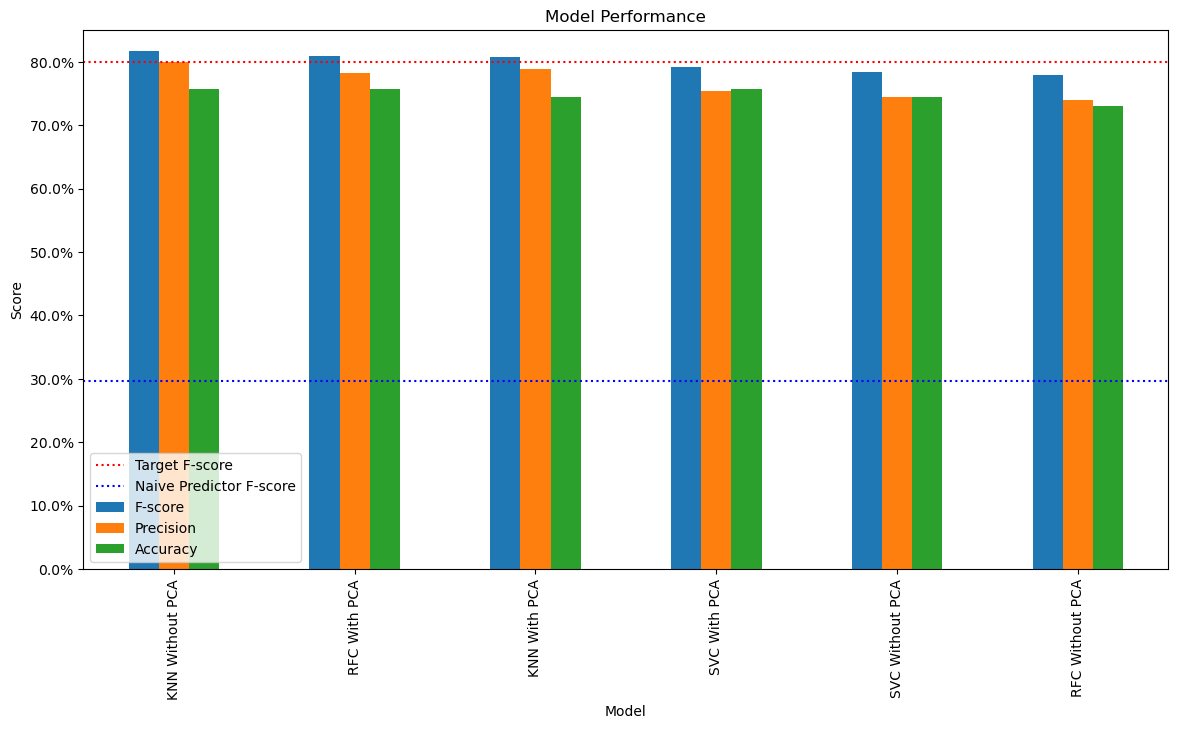

In [20]:
import matplotlib.ticker as ticker
plt.figure(figsize=(14,7))
plt.title('Model Performance')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim((0,0.85))
plt.axhline(y=0.8, color='r', linestyle='dotted', label='Target F-score')
plt.axhline(y=time_df.iloc[0]['F-score'], color='b', linestyle='dotted', label='Naive Predictor F-score')
plt.legend()

formatter = ticker.FuncFormatter(lambda y, pos: f'{round(y * 100, 0)}%')
plt.gca().yaxis.set_major_formatter(formatter)

time_df.iloc[range(1,len(time_df.index))].sort_values('F-score', ascending= False).plot.bar(x='Model', y=['F-score', 'Precision', 'Accuracy'], ax=plt.gca());


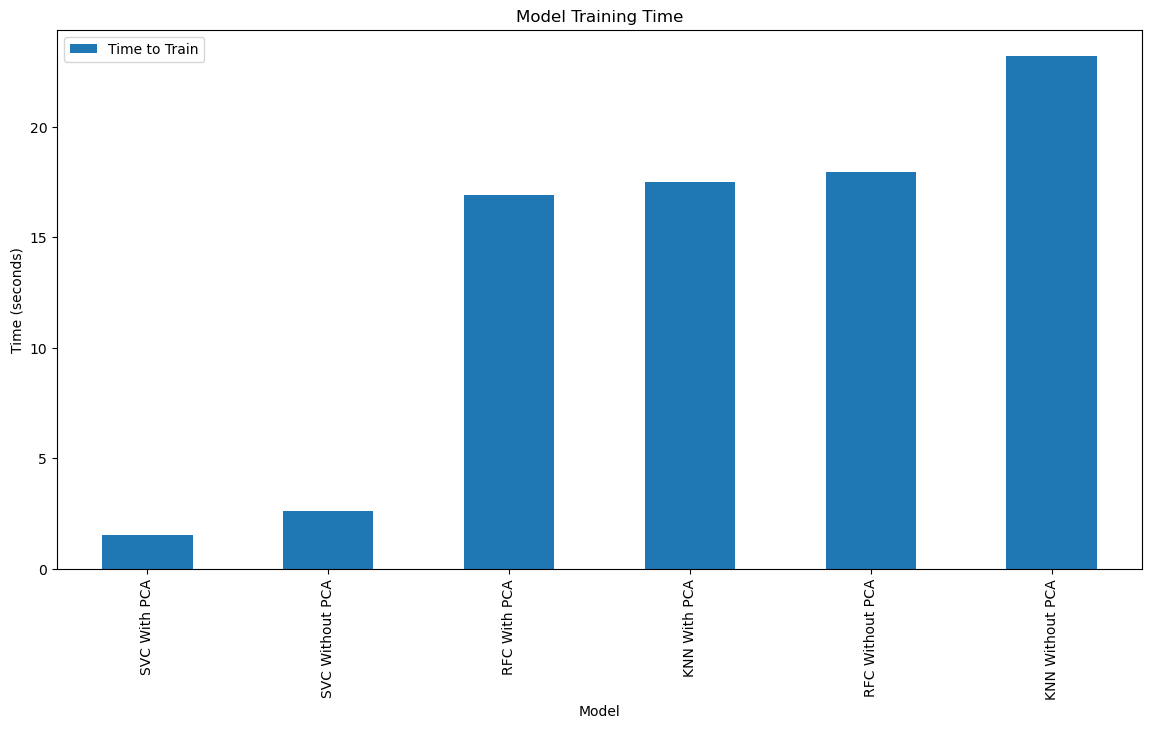

In [21]:
plt.figure(figsize=(14,7))
plt.title('Model Training Time')
plt.ylabel('Time (seconds)')
plt.xlabel('Model')

time_df.iloc[range(1,len(time_df.index))].sort_values('Time to Train', ascending= True).plot.bar(x='Model', y='Time to Train', ax=plt.gca());

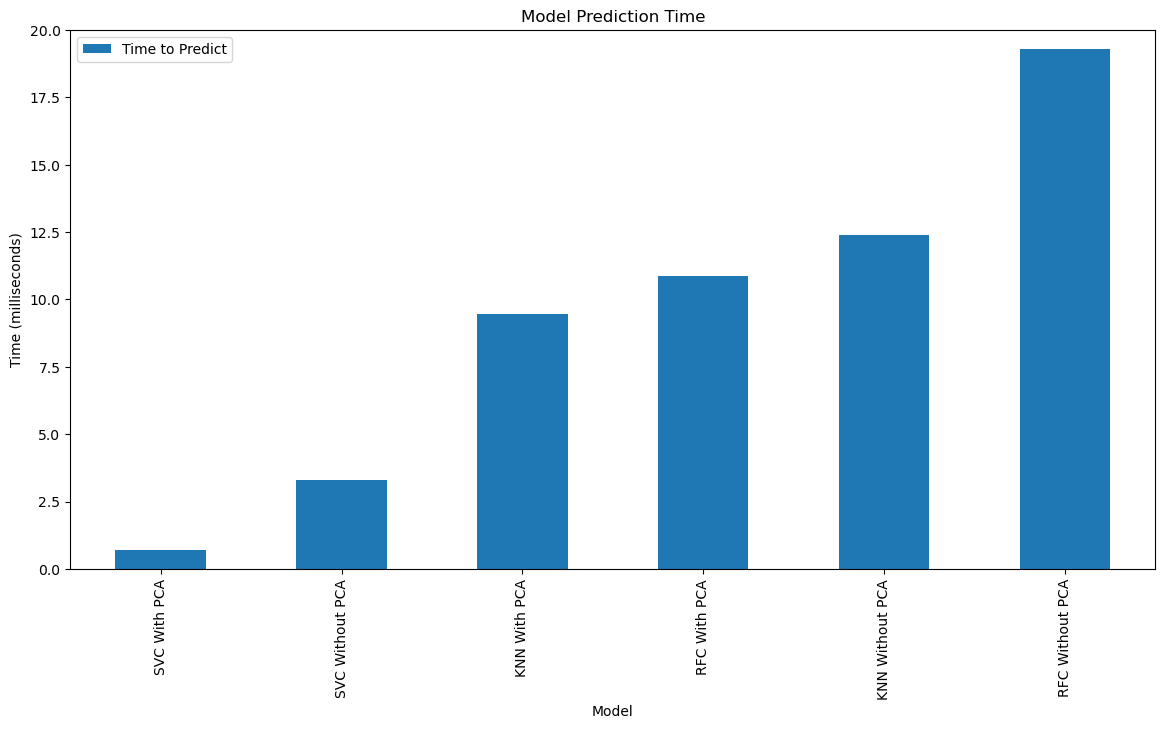

In [22]:
plt.figure(figsize=(14,7))
plt.title('Model Prediction Time')
plt.ylabel('Time (milliseconds)')
plt.xlabel('Model')
plt.ylim((0,0.02))

# Use FuncFormatter to apply a lambda to the y-values
formatter = ticker.FuncFormatter(lambda y, pos: f'{y * 1000}')
plt.gca().yaxis.set_major_formatter(formatter)

time_df.iloc[range(1,len(time_df.index))].sort_values('Time to Predict', ascending= True).plot.bar(x='Model', y='Time to Predict', ax=plt.gca());